# $k$-NN classifier using `scikit-learn`

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics, model_selection as ms, neighbors, preprocessing
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
var_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

Read in the [Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset.

In [3]:
iris = pd.read_csv('datasets/iris.csv', header=None, names=var_names)

## EDA

In [4]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [7]:
iris['species'].value_counts()

Iris-virginica     50
Iris-versicolor    50
Iris-setosa        50
Name: species, dtype: int64

## Visualisation

Look for differences between species.

In [8]:
iris.groupby('species').mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
Iris-setosa,5.006,3.428,1.462,0.246
Iris-versicolor,5.936,2.770,4.260,1.326
Iris-virginica,6.588,2.974,5.552,2.026


In [9]:
iris.groupby('species').describe()

petal_length                                               \
                       count   mean       std  min  25%   50%    75%  max   
species                                                                     
Iris-setosa             50.0  1.462  0.173664  1.0  1.4  1.50  1.575  1.9   
Iris-versicolor         50.0  4.260  0.469911  3.0  4.0  4.35  4.600  5.1   
Iris-virginica          50.0  5.552  0.551895  4.5  5.1  5.55  5.875  6.9   

                petal_width        ...  sepal_length      sepal_width         \
                      count   mean ...           75%  max       count   mean   
species                            ...                                         
Iris-setosa            50.0  0.246 ...           5.2  5.8        50.0  3.428   
Iris-versicolor        50.0  1.326 ...           6.3  7.0        50.0  2.770   
Iris-virginica         50.0  2.026 ...           6.9  7.9        50.0  2.974   

                                                        
                      std  min    25%  50%    75%  max  
species                                                 
Iris-setosa      0.379064  2.3  3.200  3.4  3.675  4.4  
Iris-versicolor  0.313798  2.0  2.525  2.8  3.000  3.4  
Iris-virginica   0.322497  2.2  2.800  3.0  3.175  3.8  

[3 rows x 32 columns]

Box plot of all numeric columns grouped by species:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001780CF24EB8>,
      dtype=object)

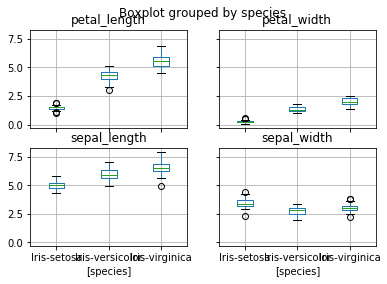

In [10]:
iris.boxplot(by='species')

Scatter matrix of all predictors coloured by species:

C:\Users\Phoenix\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


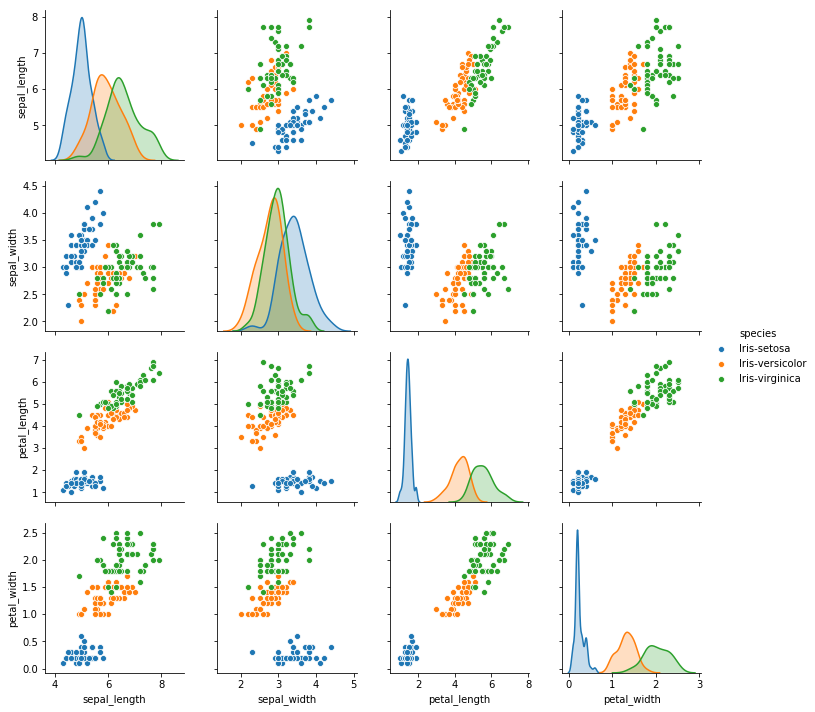

In [11]:
sns.pairplot(iris, hue='species')

Box plot of petal length by species:

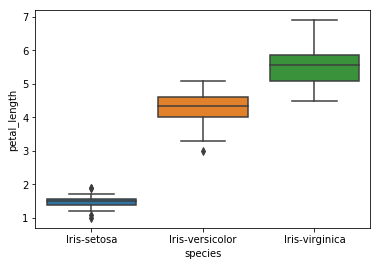

In [12]:
sns.boxplot(x='species', y='petal_length', data=iris)

Alternatively…

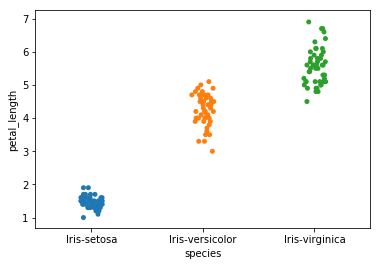

In [13]:
sns.stripplot(x='species', y='petal_length', data=iris, jitter=True)

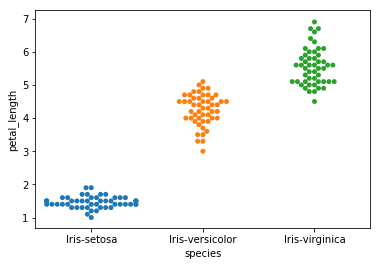

In [14]:
sns.swarmplot(x='species', y='petal_length', data=iris)

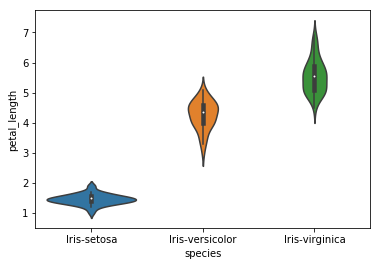

In [15]:
sns.violinplot(x='species', y='petal_length', data=iris)

Scatter plot of petal length versus petal width with density estimates:

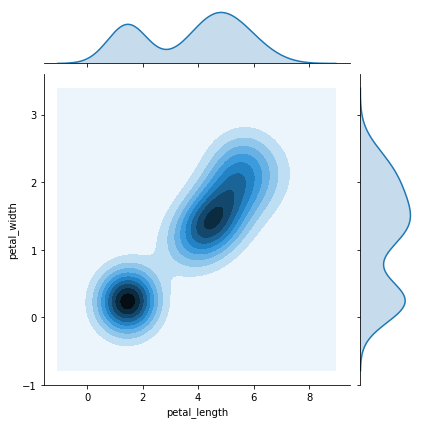

In [16]:
sns.jointplot(x='petal_length', y='petal_width', data=iris, kind='kde')

Define new predictor (petal area).

In [17]:
iris['petal_area'] = iris['petal_length'] * iris['petal_width']

Look for differences in petal area between species:

In [18]:
iris.groupby('species')['petal_area'].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
Iris-setosa,50.0,0.3656,0.181155,0.11,0.2800,0.300,0.42,0.96
Iris-versicolor,50.0,5.7204,1.368403,3.30,4.8600,5.615,6.75,8.64
Iris-virginica,50.0,11.2962,2.157412,7.50,9.7175,11.445,12.79,15.87


Box plot of petal area by species:

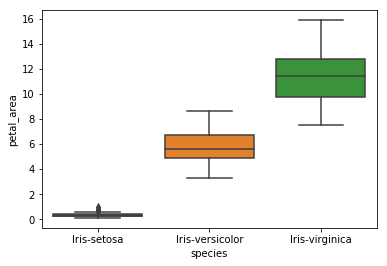

In [19]:
sns.boxplot(x='species', y='petal_area', data=iris)

Extract observations that cannot be linearly separated by petal area.

In [20]:
iris[(iris['petal_area'] >= 7.5) & (iris['petal_area'] <= 8.64)].sort_values('petal_area')

,sepal_length,sepal_width,petal_length,petal_width,species,petal_area
119,6.0,2.2,5.0,1.5,Iris-virginica,7.50
56,6.3,3.3,4.7,1.6,Iris-versicolor,7.52
106,4.9,2.5,4.5,1.7,Iris-virginica,7.65
133,6.3,2.8,5.1,1.5,Iris-virginica,7.65
134,6.1,2.6,5.6,1.4,Iris-virginica,7.84
83,6.0,2.7,5.1,1.6,Iris-versicolor,8.16
77,6.7,3.0,5.0,1.7,Iris-versicolor,8.50
70,5.9,3.2,4.8,1.8,Iris-versicolor,8.64
126,6.2,2.8,4.8,1.8,Iris-virginica,8.64
138,6.0,3.0,4.8,1.8,Iris-virginica,8.64


## Confusion matrix

Define a function to predict the species based on petal area only.

In [21]:
def classify_iris(row):
    if row['petal_area'] < 2:
        return 'Iris-setosa'
    elif row['petal_area'] < 7.5:
        return 'Iris-versicolor'
    else:
        return 'Iris-virginica'

Add predictions to DataFrame.

In [22]:
iris['prediction'] = iris.apply(classify_iris, axis=1)

Compute confusion matrix.

In [23]:
metrics.confusion_matrix(iris['species'], iris['prediction'])

array([[50,  0,  0],
       [ 0, 46,  4],
       [ 0,  0, 50]], dtype=int64)

In [24]:
pd.crosstab(iris['species'], iris['prediction'])

prediction,Iris-setosa,Iris-versicolor,Iris-virginica
species,,,
Iris-setosa,50,0,0
Iris-versicolor,0,46,4
Iris-virginica,0,0,50


## $k$-nearest neighbours classifier

Prepare data.

In [25]:
X = iris.loc[:, 'sepal_length':'petal_width']
y = iris['species'].factorize()[0]

Estimate a $k$-NN model with all points in the neighbourhood weighted equally.

In [43]:
scaled_uniform_knn = Pipeline([
    ('std', preprocessing.StandardScaler()),
    ('knn', neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform'))
])


scaled_uniform_knn.fit(X, y)

Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])

Compute accuracy.

In [44]:
metrics.accuracy_score(y, scaled_uniform_knn.predict(X))

0.9533333333333334

In [45]:
np.mean(y == scaled_uniform_knn.predict(X))

0.9533333333333334

Estimate a $k$-NN model with points in the neighbourhood weighted by the inverse of their distance.

In [46]:
scaled_distance_knn = Pipeline([
    ('std', preprocessing.StandardScaler()),
    ('knn', neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance'))
])
scaled_distance_knn.fit(X, y)

Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance'))])

In [47]:
metrics.accuracy_score(y, scaled_distance_knn.predict(X))

1.0

Determine 'optimal' number of neighbours and weighting using grid search with cross-validation.

In [48]:
cv = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [49]:
scaled_knn = Pipeline([
    ('std', preprocessing.StandardScaler()),
    ('knn', neighbors.KNeighborsClassifier())
])

In [50]:
gs = ms.GridSearchCV(estimator=scaled_knn,
                     param_grid={'knn__n_neighbors': np.arange(2, 50),
                                 'knn__weights': ['uniform', 'distance']},
                     scoring='accuracy',
                     cv=cv)
gs.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'knn__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), 'knn__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

'Best' model accuracy:

In [51]:
gs.best_score_

0.9666666666666667

'Best' model:

In [54]:
gs.best_estimator_.named_steps['knn']

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='distance')

Confusion matrix of 'best' model:

In [55]:
metrics.confusion_matrix(y, gs.best_estimator_.predict(X))

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]], dtype=int64)